# Using lifelines to fit KM curves

References:<br>
  - https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html  # noqa

In [1]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.datasets import load_waltons
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell  # noqa

In [3]:
InteractiveShell.ast_node_interactivity = "all"

## Example 1

In [4]:
waltons = load_waltons()
waltons.columns = ["time", "event", "group"]
waltons.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
time,163,NaN,NaN,NaN,49.6135,17.078,6,41,56,61,75
event,163,NaN,NaN,NaN,0.957055,0.203357,0,1,1,1,1
group,163,2,control,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<lifelines.KaplanMeierFitter:"waltons_data", fitted with 163 total observations, 7 right-censored observations>

<AxesSubplot:xlabel='timeline'>

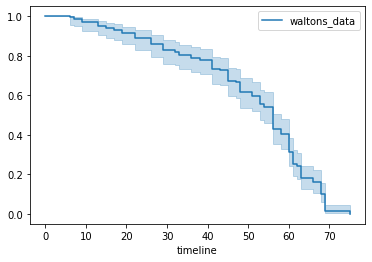

In [5]:
kmf = KaplanMeierFitter(label="waltons_data")
kmf.fit(waltons["time"], waltons["event"])
kmf.plot_survival_function()
plt.show()

## Smoothing the survival curve by using smoothed hazard function

Reference: [github link](https://github.com/nayefahmad/survival-analysis-notes/blob/main/src/2022-02-09_smoothing-the-km-estimate.md) # noqa

This is the `gastricXelox` data in R package `asaur`.

In [6]:
time_months = [
    0.9256198,
    1.8512397,
    1.8512397,
    1.8512397,
    2.0826446,
    2.5454545,
    2.7768595,
    3.0082645,
    3.7024793,
    3.7024793,
    3.9338843,
    3.9338843,
    4.3966942,
    4.8595041,
    5.5537190,
    5.5537190,
    5.7851240,
    6.4793388,
    6.4793388,
    6.9421488,
    8.5619835,
    8.5619835,
    9.7190083,
    9.9504132,
    9.9504132,
    10.6446281,
    11.1074380,
    11.5702479,
    11.8016529,
    12.2644628,
    12.4958678,
    13.1900826,
    13.6528926,
    13.6528926,
    13.8842975,
    14.8099174,
    15.2727273,
    17.5867769,
    18.0495868,
    21.0578512,
    27.5371901,
    27.7685950,
    32.1652893,
    40.7272727,
    43.2727273,
    46.9752066,
    50.2148760,
    58.5454545,
]

In [7]:
delta = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
]

KM curve:

<lifelines.KaplanMeierFitter:"gastricXelox data", fitted with 48 total observations, 16 right-censored observations>

<AxesSubplot:xlabel='timeline'>

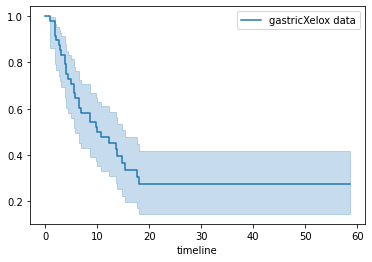

In [8]:
km2 = KaplanMeierFitter(label="gastricXelox data")
km2.fit(time_months, delta)
km2.plot_survival_function()
plt.show()

## Nelson-Aalen-based cumulative hazard function and smoothed hazard fn:

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 48 total observations, 16 right-censored observations>

<AxesSubplot:xlabel='timeline'>

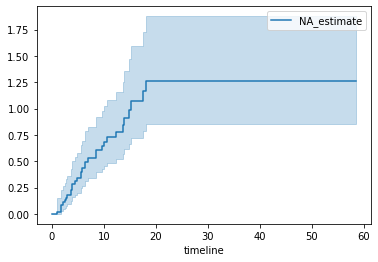

In [9]:
na1 = NelsonAalenFitter()
na1.fit(time_months, delta)
na1.plot_cumulative_hazard()
plt.show()

<AxesSubplot:>

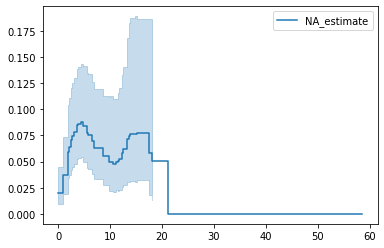

In [10]:
bandwidth = 3
na1.plot_hazard(bandwidth=bandwidth)
plt.show()

Recover the data using the `smoothed_hazard_()` method

In [11]:
df_smoothed_hazard = na1.smoothed_hazard_(bandwidth=bandwidth)
df_smoothed_hazard.head()
df_smoothed_hazard.tail()

,differenced-NA_estimate
0.000000,0.020236
0.925620,0.037579
1.851240,0.059442
2.082645,0.064217
2.545454,0.070805


,differenced-NA_estimate
40.727273,0.0
43.272727,0.0
46.975207,0.0
50.214876,0.0
58.545454,0.0
